# 1. Business Understanding

## Contexto
O dataset **Global Cybersecurity Threats (2015–2024)** reúne incidentes de segurança digital em diversos países e setores. Cada linha descreve um ataque, incluindo tipo, indústria-alvo, prejuízo financeiro, número de usuários afetados, vulnerabilidade explorada, mecanismo de defesa e tempo de resolução.

O objetivo deste projeto é aplicar técnicas de **Ciência de Dados** para responder a duas questões centrais de negócios:

1. **Quem foi o atacante?**  
   Após conter um incidente, equipes de cibersegurança precisam estimar **quem foi o pivô do ataque** (e.g., Hacker Group, Insider, Nation-state, Unknown).  
   - **Métrica de sucesso**: *Log Loss*, pois o valor real está em retornar probabilidades que apoiem a investigação e permitam priorizar hipóteses.
   - **Métrica auxiliar**: *F1-Macro*, usada para avaliar se o modelo trata todas as classes de forma justa.  
     - Isso é importante porque, mesmo com classes balanceadas, o modelo pode priorizar algumas classes em detrimento de outras. O F1-Macro garante que avaliemos o desempenho médio por classe.    
   - **Baselines**: 
     - Sempre prever a classe majoritária (moda).  
     - Prever a distribuição empírica das classes (priors).  


2. **Quanto tempo e quanto será gasto para resolver o incidente? (Ainda não implementado)**  
   Além de identificar o atacante, também é relevante prever o **Incident Resolution Time (em horas)** e o **Financial Loss (em milhões de dólares)** como proxies de custo direto.  
     
   - A previsão do **tempo e custo** ainda não foi implementada, mas será tratada em etapas futuras. Podemos modelar esse cenário de duas formas:
     - **Multioutput regression**: um único modelo para prever tempo e custo simultaneamente.  
     - **Modelos separados**: um modelo específico para tempo e outro para custo.  

   **Métricas de sucesso para regressão**:  
   - *MAE* (erro médio absoluto, fácil de interpretar em horas ou milhões de dólares).  
   - *RMSE* (penaliza mais erros grandes).  
   - *R²* (quanto da variabilidade é explicada pelo modelo).  


## Formulação do Problema de Negócio:
> **Situação em que o incidente já foi contido. Agora precisamos apoiar a decição critica de:**
> - Estimar **quem foi o atacante**, com probabilidades para guiar a investigação, esforços e futuras melhorias a serem implementadas para a segurança do sistema.    


# 2. Data Understanding

In [1]:
# Import required libraries and suppress warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib
matplotlib.use('Agg')  # Ensures non-GUI backend for matplotlib
import matplotlib.pyplot as plt
plt.switch_backend('Agg')  # If using only plt, switch backend to Agg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set_style('darkgrid')

import seaborn as sns


# Inline plotting for Kaggle notebooks
%matplotlib inline

# Set visualisation style
sns.set(style='whitegrid')

## 2.1 Carregamento do Dataset
Nesta etapa carregamos o dataset bruto e verificamos a dimensão e as primeiras linhas, para ter uma ideia da granularidade e consistência dos dados.


In [2]:
# Load the dataset
data_path = '/kaggle/input/global-cybersecurity-threats-2015-2024/Global_Cybersecurity_Threats_2015-2024.csv'
df = pd.read_csv(data_path, delimiter=',', encoding='ascii')

print("Dimensão do dataset:", df.shape)
df.head()

Dimensão do dataset: (3000, 10)


,Country,Year,Attack Type,Target Industry,Financial Loss (in Million $),Number of Affected Users,Attack Source,Security Vulnerability Type,Defense Mechanism Used,Incident Resolution Time (in Hours)
0,China,2019,Phishing,Education,80.53,773169,Hacker Group,Unpatched Software,VPN,63
1,China,2019,Ransomware,Retail,62.19,295961,Hacker Group,Unpatched Software,Firewall,71
2,India,2017,Man-in-the-Middle,IT,38.65,605895,Hacker Group,Weak Passwords,VPN,20
3,UK,2024,Ransomware,Telecommunications,41.44,659320,Nation-state,Social Engineering,AI-based Detection,7
4,Germany,2018,Man-in-the-Middle,IT,74.41,810682,Insider,Social Engineering,VPN,68


## 2.2 Estrutura das Variáveis
Aqui avaliamos os tipos de dados, presença de valores nulos e estatísticas descritivas iniciais.


In [3]:
# Here’s a quick glimpse of our dataset:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Country                              3000 non-null   object 
 1   Year                                 3000 non-null   int64  
 2   Attack Type                          3000 non-null   object 
 3   Target Industry                      3000 non-null   object 
 4   Financial Loss (in Million $)        3000 non-null   float64
 5   Number of Affected Users             3000 non-null   int64  
 6   Attack Source                        3000 non-null   object 
 7   Security Vulnerability Type          3000 non-null   object 
 8   Defense Mechanism Used               3000 non-null   object 
 9   Incident Resolution Time (in Hours)  3000 non-null   int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 234.5+ KB


In [4]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Country,3000,10,UK,321,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,3000.0,NaN,NaN,NaN,2019.570333,2.857932,2015.0,2017.0,2020.0,2022.0,2024.0
Attack Type,3000,6,DDoS,531,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Target Industry,3000,7,IT,478,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Financial Loss (in Million $),3000.0,NaN,NaN,NaN,50.49297,28.791415,0.5,25.7575,50.795,75.63,99.99
Number of Affected Users,3000.0,NaN,NaN,NaN,504684.136333,289944.084972,424.0,255805.25,504513.0,758088.5,999635.0
Attack Source,3000,4,Nation-state,794,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Security Vulnerability Type,3000,4,Zero-day,785,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Defense Mechanism Used,3000,5,Antivirus,628,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Incident Resolution Time (in Hours),3000.0,NaN,NaN,NaN,36.476,20.570768,1.0,19.0,37.0,55.0,72.0


In [5]:
df.isnull().sum()

Country                                0
Year                                   0
Attack Type                            0
Target Industry                        0
Financial Loss (in Million $)          0
Number of Affected Users               0
Attack Source                          0
Security Vulnerability Type            0
Defense Mechanism Used                 0
Incident Resolution Time (in Hours)    0
dtype: int64

## 2.3 Duplicatas
Primeiro verificamos duplicatas considerando todas as colunas.  


In [6]:
# Duplicatas completas
print("Duplicatas completas:", df.duplicated().sum())


Duplicatas completas: 0


## 2.4 Papel da variável *Defense Mechanism Used*

Uma dúvida inicial do projeto foi:  
**o campo `Defense Mechanism Used` representa o mecanismo de defesa que já existia antes do ataque ou o mecanismo adotado após o ataque?**

Para investigar, verificamos **Duplicatas ignorando `Defense Mechanism Used`**: para identificar incidentes idênticos em tudo, mas registrados mais de uma vez apenas porque o mecanismo de defesa foi diferente.

In [7]:
# Duplicatas ignorando Defense Mechanism Used
df_no_defense = df.drop(columns=["Defense Mechanism Used"])
dup_rows = df_no_defense.duplicated(keep=False).sum()
print("Duplicatas ignorando Defense Mechanism Used:", dup_rows)


Duplicatas ignorando Defense Mechanism Used: 0


### Resultados
- **Não encontramos registros duplicados ignorando a coluna de defesa.**  
- Isso sugere que, no dataset atual, cada incidente foi registrado de forma **única**, com apenas um valor de `Defense Mechanism Used`.

### Discussão
Na prática, em um cenário real de cibersegurança, é comum que **mais de um mecanismo de defesa seja aplicado para lidar com o mesmo ataque** (por exemplo: *Firewall + VPN + AI-based detection*).  
Se o sistema de registro não permitir selecionar múltiplos valores, isso pode gerar problemas de inserção, como:  
- O mesmo incidente ser inserido **duas ou mais vezes**, mudando apenas o campo `Defense Mechanism Used`.  
- Cada linha representando **um par (incidente, defesa aplicada)**, e não o incidente em si.  

Como não observamos esse padrão de duplicação, temos duas hipóteses:  
1. O dataset foi normalizado de forma a manter **um único registro por ataque**, armazenando apenas **um mecanismo de defesa principal**.  
2. Durante a coleta dos dados, optou-se por registrar **somente a primeira ou a mais relevante defesa aplicada**, ignorando combinações múltiplas.  

### Conclusão
Dessa forma, interpretamos que `Defense Mechanism Used` provavelmente se refere ao **mecanismo de defesa principal escolhido após o ataque**.  
Ainda assim, documentamos o risco de que a variável não represente todo o conjunto de medidas realmente utilizadas em um incidente real.

## 2.4 Validação Lógica de Valores
Como variáveis como perdas financeiras, número de usuários afetados e tempo de resolução não fazem sentido com valores negativos ou zero, validamos a presença de inconsistências.

In [8]:
num_cols = df.select_dtypes(include="number").columns.tolist()

for col in num_cols:
    invalid_count = (df[col] <= 0).sum()
    if invalid_count > 0:
        print(f"{col}: {invalid_count} valores <= 0")


## Variáveis uteis para responder a questão de negócio 1 (decisões tomadas e motivos):


- **Country**: será utilizada.  
  Cada país possui contextos diferentes em termos de maturidade em segurança cibernética, políticas de proteção de dados, exposição a grupos hackers e até mesmo relevância geopolítica. Esses fatores podem influenciar tanto o tipo de atacante quanto o tempo necessário para a resolução do incidente.  

- **Year**: não será utilizada como variável preditora.  
  Apesar de ser relevante para análise exploratória e para separar os dados em treino e teste (split temporal), o uso do `Year` em predição apresenta riscos:  
  - O dataset só vai até 2024, o que faria o modelo aprender padrões específicos desse período sem generalizar para anos futuros (ex.: 2025).  
  - O modelo poderia capturar tendências artificiais (ex.: “Nation-state aumentou em 2023”), que podem não se repetir.  
  - Em validações com KFold aleatório, o `Year` poderia causar **vazamento temporal**, inflando artificialmente as métricas.  
  Assim, `Year` será usado apenas para análise de tendências históricas e como critério de separação entre treino e teste, nunca como feature de predição.  

- **Attack Type**: será utilizada.  
  O tipo de ataque (phishing, ransomware, DDoS etc.) é um dos principais indicadores de quem foi o atacante, já que grupos diferentes costumam usar estratégias distintas. Também pode influenciar o tempo de resolução, pois alguns tipos são mais fáceis de conter do que outros.  

- **Target Industry**: será utilizada.  
  Cada setor (saúde, governo, financeiro, educação, telecomunicações etc.) tem vulnerabilidades e atratividade diferentes para atacantes. Por exemplo, insiders são mais comuns em bancos, enquanto estados-nação podem visar educação e pesquisa.  

- **Financial Loss (in Million $)**: será utilizada, com ressalvas.  
  Essa variável representa o prejuízo financeiro associado ao incidente. Entretanto, o dataset não deixa claro se se trata de perda **direta** (custos imediatos de resposta ao ataque) ou **indireta** (impactos posteriores, como processos judiciais, perda de clientes, reputação etc.).  
  Neste projeto, vamos assumir que a variável representa **perdas diretas**, pois são as mais objetivas e factíveis de estimar. Essa escolha também facilita a utilização como alvo futuro em modelos de regressão para prever custo.  
  Além disso, podemos verificar se existe correlação com `Number of Affected Users` para explorar indícios de perdas indiretas.  

- **Number of Affected Users**: será utilizada.  
  Representa a quantidade de usuários impactados pelo incidente. Pode ser tanto uma medida de impacto direto (quanto mais usuários, maior o dano) quanto um fator que influencia tempo e custo de resolução. É plausível que esteja associado ao tipo de atacante: ataques massivos costumam afetar mais usuários, enquanto ataques internos (insiders) podem ser mais restritos.  

- **Security Vulnerability Type**: será utilizada.  
  Identifica a vulnerabilidade explorada (ex.: software desatualizado, senhas fracas, engenharia social). Essa é uma variável diretamente relacionada ao modus operandi do atacante e pode ajudar bastante a distinguir entre diferentes grupos.  

- **Defense Mechanism Used**: será utilizada, mas com cautela.  
  A maior dúvida é se este campo representa o mecanismo de defesa já existente **antes do ataque** ou aquele que foi **adotado após o incidente**.
  - Se for antes do ataque, é totalmente válido como feature (mostra o nível de proteção do sistema).  
  - Se for após o ataque, pode gerar **data leakage** (usar informação do futuro para prever o passado).  
  Neste projeto (levando em conta a analise que fizemos), assumiremos que representa o mecanismo escolhido para lidar com a situação após a detecção. Nesse cenário, a justificativa para manter a variável é que, em casos práticos, essa informação estaria disponível logo após a contenção e, portanto, poderia ser usada em apoio à investigação.  

- **Inciden Resolution Time (in Hours)**: será utilizada.  
  Representa o tempo necessário para resolver o incidente. Prever esse valor é útil para estimar SLAs, custos de resposta e alocação de equipes.  

## Definição do target e metricas de avaliação para o problema de negócio 1:
- **Attack Source**: alvo da classificação.  
  É a variável que queremos prever para identificar quem foi o pivô do ataque (Hacker Group, Insider, Nation-state ou Unknown). Essa previsão deve ser probabilística, para apoiar a investigação.  
  - **Métrica principal**: Log Loss (qualidade das probabilidades).  
  - **Métrica auxiliar**: F1-Macro, para verificar se o modelo mantém equilíbrio no acerto entre todas as classes, evitando favorecer apenas algumas.    



# 3. Estratégia de Separação em Treino e Teste

Em projetos de Ciência de Dados, é fundamental que os **dados de teste** sejam tratados como se fossem **dados completamente novos em produção**.  
Isso significa que:

- O conjunto de teste **não deve influenciar nenhuma decisão de modelagem**, nem no pré-processamento, nem na análise exploratória, nem na escolha de variáveis.  
- Ele deve ser utilizado **apenas uma vez, no final**, para avaliar o desempenho real do modelo em um cenário que simula dados futuros.

No nosso caso, o dataset contém a variável temporal **`Year`**, o que permite aplicar um **split temporal**. Essa estratégia é mais adequada do que uma divisão aleatória porque:

1. **Respeita a ordem cronológica dos eventos**, simulando a realidade: treinamos o modelo em dados de anos anteriores e testamos em anos posteriores.  
2. Evita **vazamento de informação** (data leakage), já que ataques futuros não poderiam ser conhecidos durante o treinamento.  
3. Cria um ambiente mais próximo da produção, em que o modelo é desafiado a generalizar para padrões de ataques que ainda não apareceram no histórico.

### Metodologia adotada
- Os dados foram **ordenados por ano em ordem crescente**.  
- Definimos **80% dos registros iniciais** como **treino** e os **20% finais** como **teste**.  
- Assim, o conjunto de treino é utilizado para **exploração, preparação e desenvolvimento do modelo**, enquanto o conjunto de teste é mantido isolado, servindo exclusivamente para a **avaliação final**.  

Essa abordagem garante uma avaliação mais justa da capacidade de generalização do modelo em um ambiente real de cibersegurança, onde incidentes futuros podem apresentar **novos padrões, combinações de vulnerabilidades e defesas**.


In [9]:
# Ordenar por ano
df_sorted = df.sort_values(by="Year").reset_index(drop=True)

# Definir ponto de corte
split_index = int(len(df_sorted) * 0.8)

# Criar conjuntos de treino e teste
train_df = df_sorted.iloc[:split_index]
test_df  = df_sorted.iloc[split_index:]

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# Conferir anos no treino e teste
print("\nAno mínimo e máximo (Treino):", train_df["Year"].min(), "-", train_df["Year"].max())
print("Ano mínimo e máximo (Teste):", test_df["Year"].min(), "-", test_df["Year"].max())
df = train_df

Train shape: (2400, 10)
Test shape: (600, 10)

Ano mínimo e máximo (Treino): 2015 - 2023
Ano mínimo e máximo (Teste): 2023 - 2024


# 4. Análise Exploratória dos Dados (EDA)

Após a separação entre treino e teste, conduzimos a **Análise Exploratória dos Dados (EDA)** exclusivamente no conjunto de **treino**, garantindo que nenhuma informação do teste influencie nossas decisões de modelagem.

O objetivo da EDA é compreender melhor os dados disponíveis, identificar padrões, relações entre variáveis e potenciais problemas.  

### 4.1 Estatísticas descritivas com formatação

Nesta etapa usamos `df.describe()` com formatação visual para analisar a distribuição das variáveis numéricas.  
A ideia é destacar **médias, dispersão (desvio padrão)** e **mediana**, facilitando a comparação entre variáveis em diferentes escalas.


In [10]:
df.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
Year,2400.000000,2018.588333,2.307470,2015.000000,2017.000000,2019.000000,2021.000000,2023.000000
Financial Loss (in Million $),2400.000000,50.262667,28.848126,0.500000,25.632500,50.150000,75.640000,99.990000
Number of Affected Users,2400.000000,506040.062917,290206.131490,424.000000,257159.500000,510882.500000,761286.500000,999545.000000
Incident Resolution Time (in Hours),2400.000000,36.473333,20.682844,1.000000,19.000000,37.000000,55.000000,72.000000


### Interpretação

- **Year**: varia pouco (2015 a 2023), funcionando mais como referência temporal.  
- **Financial Loss (in Million $)**: varia de ~0.5 até ~100 milhões, média ~50.  
- **Number of Affected Users**: varia de centenas até quase 1 milhão, média ~500k.  
- **Inciden Resolution Time (in Hours)**: varia de 1 até 72 horas, média ~36h.  

➡️ Observamos uma **grande diferença de escala entre as variáveis**: valores que vão de dezenas (horas) até centenas de milhares (usuários).  

Isso significa que, caso utilizemos **modelos sensíveis à escala** (como Regressão Logística, KNN ou Redes Neurais), será **essencial aplicar normalização ou padronização**.  
Já modelos baseados em árvores (Random Forest, XGBoost, LightGBM) não são impactados por transformações monótonicas, já que elas preservam a ordem das observações.


## 4.2 Análise Univariada

### 4.2.1 Análise do Target

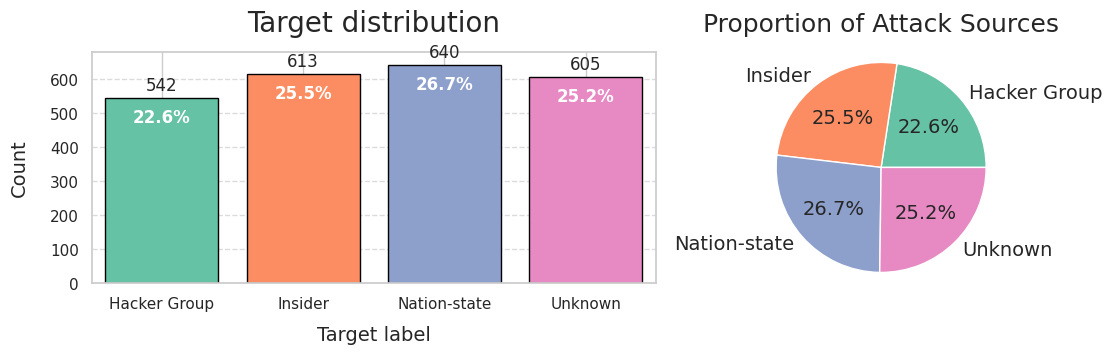

In [11]:
# Definir paleta de cores (mesmo número de classes únicas em Attack Source)
colors = sns.color_palette("Set2", n_colors=df['Attack Source'].nunique())

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 3), gridspec_kw={'width_ratios': [2, 1]})

# Dados ordenados
attack_counts = df['Attack Source'].value_counts().sort_index()

# ---- Gráfico de barras ----
bars = axs[0].bar(
    attack_counts.index,
    attack_counts.values,
    color=colors,
    edgecolor="black"
)
axs[0].set_title("Target distribution", fontsize=20, pad=15)
axs[0].set_ylabel("Count", fontsize=14, labelpad=15)
axs[0].set_xlabel("Target label", fontsize=14, labelpad=10)

# Labels numéricos
axs[0].bar_label(bars, labels=attack_counts.values, padding=3, fontsize=12)
# Labels percentuais
axs[0].bar_label(
    bars,
    labels=[f"{(x/attack_counts.sum())*100:2.1f}%" for x in attack_counts.values],
    padding=-20,
    fontsize=12,
    color="white",
    weight="bold"
)

axs[0].margins(0.025, 0.06)
axs[0].grid(axis="y", linestyle="--", alpha=0.7)

# ---- Gráfico de pizza ----
axs[1].pie(
    attack_counts.values,
    labels=attack_counts.index,
    colors=colors,
    autopct="%1.1f%%",
    textprops={"fontsize": 14}
)
axs[1].set_title("Proportion of Attack Sources", fontsize=18, pad=15)
axs[1].axis("equal")

plt.show()

### Discussão: Como lidar com a classe *Unknown* em `Attack Source`

Um ponto crítico da modelagem é decidir como tratar a classe **Unknown** em nosso alvo (`Attack Source`).  
Na prática, incidentes sem atribuição clara são comuns em cibersegurança, mas precisamos avaliar se essa categoria deve ser mantida no modelo.

### Opções de tratamento

1. **Manter como classe válida**  
   - Reflete a realidade: muitos ataques realmente não são atribuídos.  
   - O modelo aprende a reconhecer padrões que sugerem ataque não identificado.  
   - Útil se o objetivo for **realismo operacional** (aceitar que alguns ataques nunca serão atribuídos).  

2. **Remover a classe Unknown**  
   - O modelo foca apenas em atacantes conhecidos (Insider, Hacker Group, Nation-state).  
   - Vantagem: maior clareza explicativa.  
   - Desvantagem: perda de dados e de informação que poderia indicar incerteza.  
   - Útil se o objetivo for **explicabilidade limpa**.  

3. **Tratar Unknown como “outro”**  
   - Reclassificar Unknown como categoria genérica de “outlier/anomalia”.  
   - Útil em um contexto de **segurança preventiva**, para identificar ataques fora dos perfis tradicionais.  

4. **Abordagem semi-supervisionada**  
   - Usar Unknown como rótulo parcial.  
   - Exemplo: prever probabilidades de cada classe e, se nenhuma passar um certo *threshold*, marcar como Unknown.  
   - Útil se quisermos um sistema que prefira dizer **“não sei”** a cometer um erro grosseiro.  

---

### Decisão para esse projeto:
Para este estudo no Kaggle, vamos **manter Unknown como classe na primeira versão do modelo**, garantindo um baseline mais realista.  
Na sequência, podemos comparar dois cenários:  

- **Modelo A:** incluindo Unknown como classe.  
- **Modelo B:** excluindo Unknown.  

Essa comparação permitirá medir quanto a presença de Unknown afeta as métricas de classificação (ex.: F1-Macro e LogLoss).


### 4.2.2 Análise das variaveis continuas

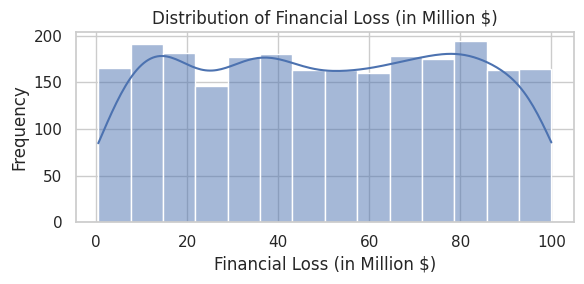

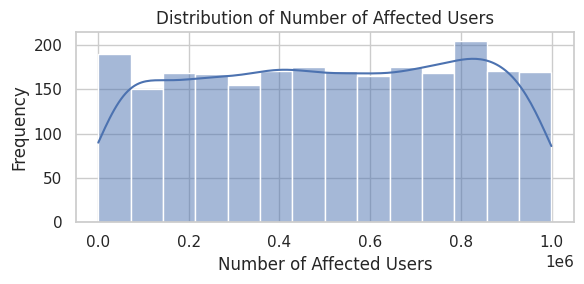

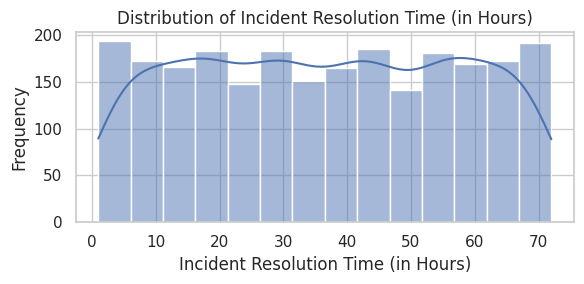

In [12]:
# Define Numeric Columns
numeric_cols = ['Financial Loss (in Million $)', 'Number of Affected Users', 'Incident Resolution Time (in Hours)']

# Plot Distributions
for col in numeric_cols:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[col], kde=True)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()

## Discussão sobre as distribuições numéricas

Ao analisar as distribuições de **Financial Loss (in Million $)**, **Number of Affected Users** e **Incident Resolution Time (in Hours)**, alguns pontos chamam atenção:

### Observações

1. **Financial Loss (in Million $)**
   - A variável apresenta uma distribuição **quase uniforme** ao longo do intervalo.  
   - Esse comportamento é atípico em dados financeiros, que normalmente seguem distribuições assimétricas, com muitos casos de perdas pequenas e poucos casos de perdas muito altas.  
   - Isso sugere que os valores foram **normalizados, discretizados ou simulados**.

2. **Number of Affected Users**
   - Também mostra uma distribuição **próxima do uniforme**, sem concentração forte em valores baixos ou altos.  
   - Em cenários reais, seria esperado que a maioria dos incidentes afetasse **poucos usuários**, enquanto apenas alguns atingiriam milhões.  
   - Mais uma vez, o padrão reforça a hipótese de dados **sintéticos ou balanceados artificialmente**.

3. **Incident Resolution Time (in Hours)**
   - A distribuição é bastante homogênea entre 0 e 70 horas.  
   - Em dados reais, o tempo de resolução tende a seguir algo mais próximo de uma **log-normal** (muitos incidentes resolvidos rapidamente, poucos demorando muito).  
   - O comportamento uniforme sugere padronização ou geração sintética.

---

### Implicações
- As distribuições analisadas **não refletem padrões típicos de incidentes reais**.  
- O aspecto positivo é que não há forte desbalanceamento, o que facilita a modelagem supervisionada.  
- O aspecto negativo é a **baixa representatividade prática**, o que exige cautela ao extrair conclusões de negócio.

---

### Origem dos dados
Pesquisando melhor, descobrimos que o dataset é de fato **sintético**.  
O criador afirma que foi gerado **a partir de dados reais**, mas dadas as distribuições homogêneas observadas, essa afirmação é **questionável**.  

Por outro lado:  
- O autor possui **boa reputação na comunidade Kaggle**, sendo inclusive *Grandmaster de Datasets*.  
- Isso aumenta a credibilidade, ainda que não possamos confiar de forma absoluta.

---

### Classificação de confiabilidade
Utilizando a escala de confiabilidade (1–6 e A–F):

- **Fonte (Autor/Dataset):** Avaliação **2 – Usualmente confiável**, dado o histórico positivo do criador.  
- **Informação (Distribuições):** Avaliação **E – Improvável**, pois os padrões não condizem com o que seria esperado em dados de cibersegurança reais.  

**Classificação final:** **2E** – fonte confiável, mas informação de baixa plausibilidade.  


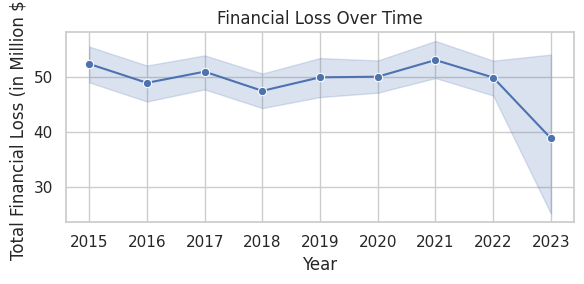

In [13]:
# Plot the sales trend over time
plt.figure(figsize=(6, 3))
sns.lineplot(data=df, x='Year', y='Financial Loss (in Million $)', marker='o')
plt.xlabel("Year")
plt.ylabel("Total Financial Loss (in Million $)")
plt.title("Financial Loss Over Time")
plt.tight_layout()
plt.show()

A redução observada em 2023 é esperada, uma vez que parte desses registros foi destinada ao conjunto de teste.  
Portanto, o volume apresentado no treino não reflete a totalidade dos dados disponíveis para esse ano.

### 4.2.3 Análise das variaveis categoricas

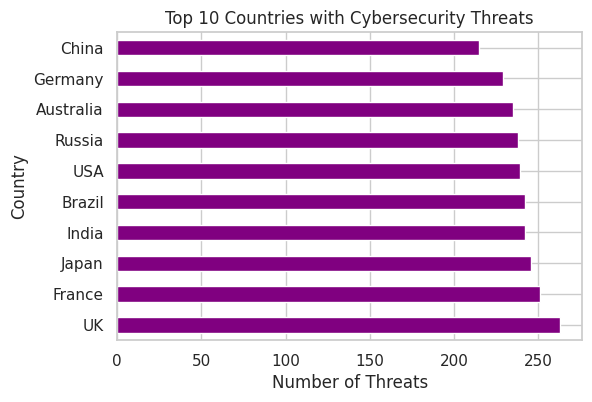

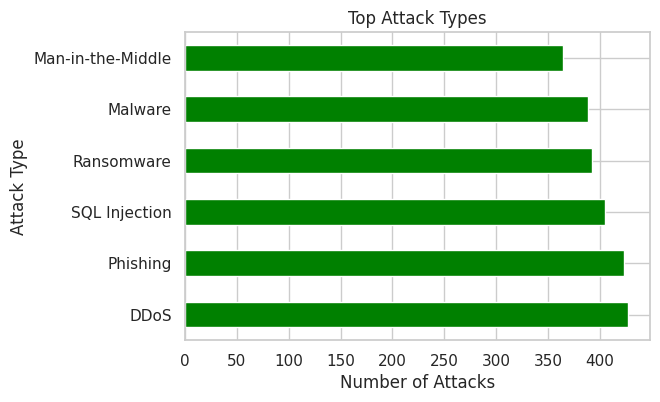

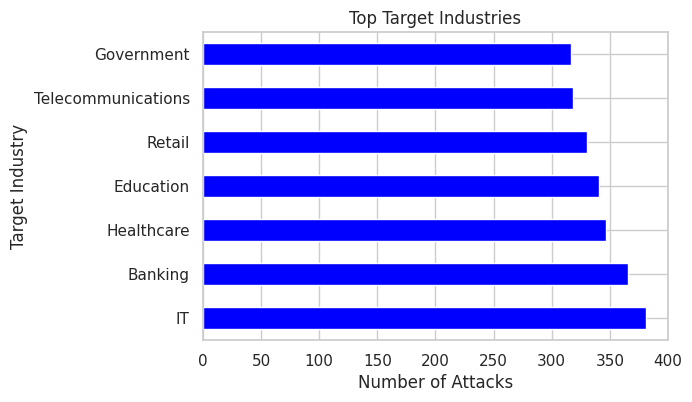

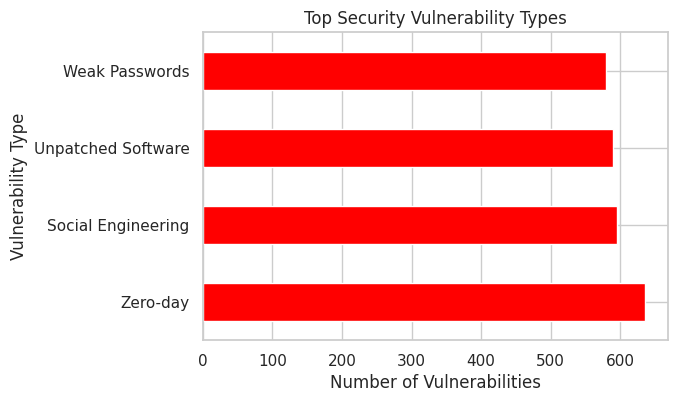

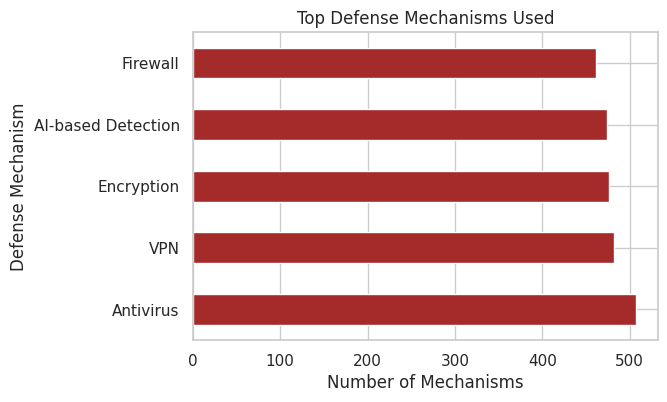

In [14]:
# Count the number of unique values in each column
# First count of unique in  country values
df["Country"].value_counts().head(10).plot(kind = "barh", figsize = (6, 4), color = "purple")
plt.title("Top 10 Countries with Cybersecurity Threats")
plt.xlabel("Number of Threats")
plt.ylabel("Country")
plt.show()

# Count of unique values in  attack types
df["Attack Type"].value_counts().plot(kind = "barh", figsize = (6, 4), color = "green")
plt.title("Top Attack Types")
plt.xlabel("Number of Attacks")
plt.ylabel("Attack Type")
plt.show()

# Count of unique values in  attack types
df["Target Industry"].value_counts().plot(kind = "barh", figsize = (6, 4), color = "blue")
plt.title("Top Target Industries")
plt.xlabel("Number of Attacks")
plt.ylabel("Target Industry")
plt.show()


# Count of unique values in  Security Vulnerability Type
df["Security Vulnerability Type"].value_counts().plot(kind = "barh", figsize = (6, 4), color = "red")
plt.title("Top Security Vulnerability Types")
plt.xlabel("Number of Vulnerabilities")
plt.ylabel("Vulnerability Type")
plt.show()

# Count of unique values in Defense Mechanism Used
df["Defense Mechanism Used"].value_counts().plot(kind = "barh", figsize = (6, 4), color = "brown")
plt.title("Top Defense Mechanisms Used")
plt.xlabel("Number of Mechanisms")
plt.ylabel("Defense Mechanism")
plt.show()

Os gráficos confirmam a hipótese de que o dataset foi construído de forma **intencionalmente balanceada**, garantindo representatividade similar para países, indústrias, atacantes e tipos de ataque. Isso é útil para fins de aprendizado de máquina (evita desbalanceamento severo), mas limita a capacidade de extrair insights realistas sobre a distribuição real dos ataques no mundo.

### 4.3 Analise Bivariada

In [15]:
# Aggregate Financial Loss by Country
df_country_loss = df.groupby('Country')['Financial Loss (in Million $)'].sum().reset_index()

# Creat the choropleth map
fig = px.choropleth(
    df_country_loss,
    locations='Country',
    locationmode='country names',
    color='Financial Loss (in Million $)',
    color_continuous_scale='Inferno',
    title="Total Financial Loss by Country"
)

fig.show(renderer='iframe')

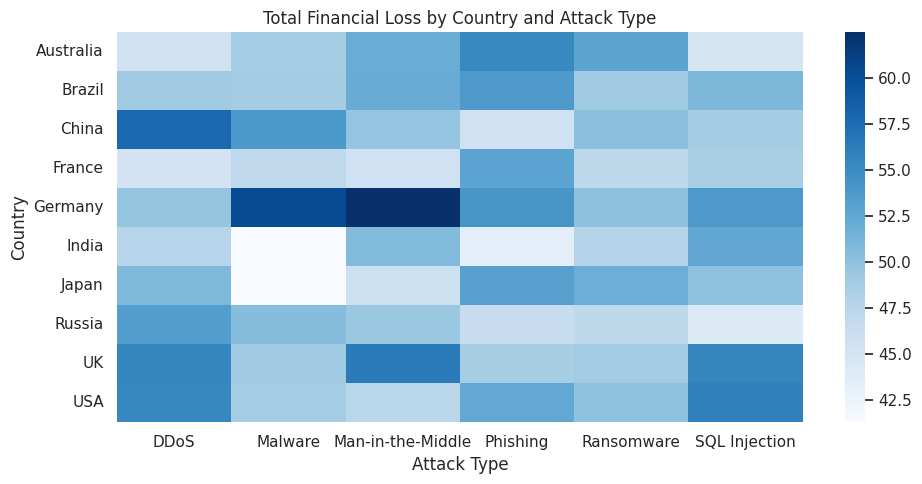

In [16]:
# Create a Pivot Table
pivot_table = df.pivot_table(index='Country', columns='Attack Type', values='Financial Loss (in Million $)')

# Plot the Heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(pivot_table, cmap='Blues')
plt.xlabel("Attack Type")
plt.ylabel("Country")
plt.title("Total Financial Loss by Country and Attack Type")
plt.tight_layout()
plt.show()

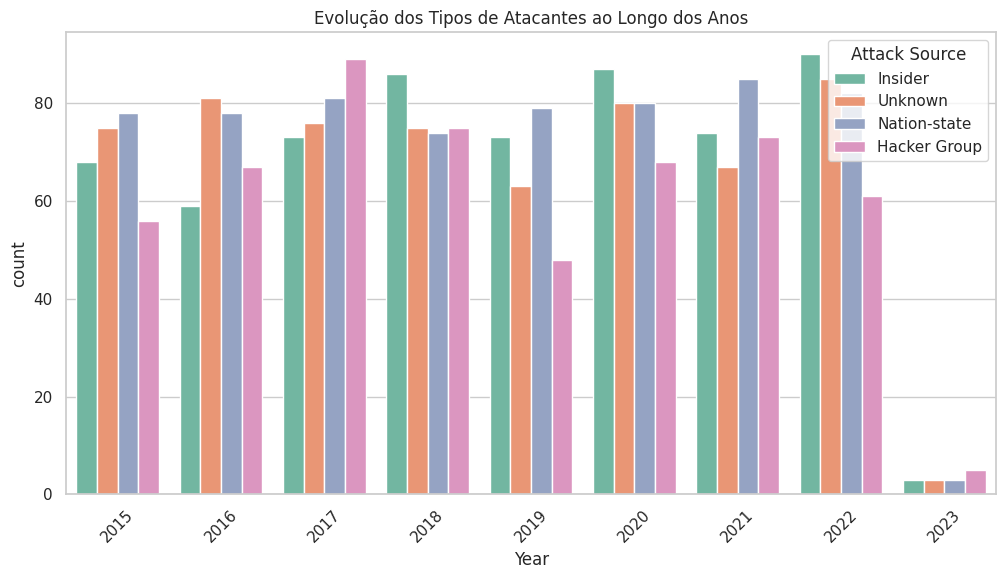

In [17]:
import seaborn as sns

plt.figure(figsize=(12,6))
sns.countplot(data=df, x="Year", hue="Attack Source", palette="Set2")
plt.title("Evolução dos Tipos de Atacantes ao Longo dos Anos")
plt.xticks(rotation=45)
plt.show()


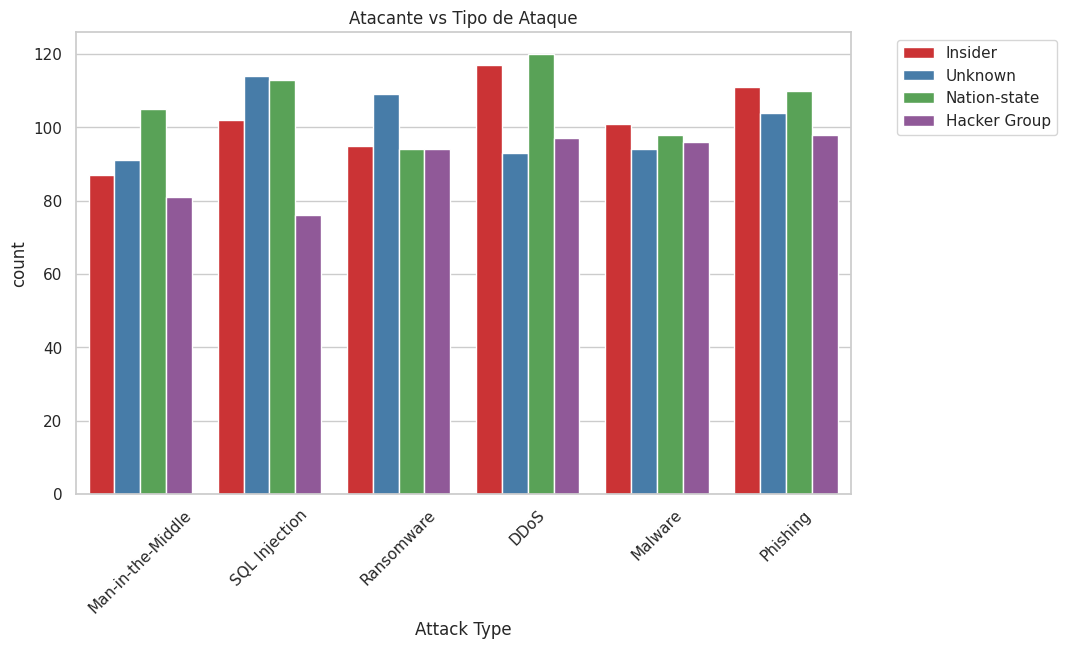

In [18]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x="Attack Type", hue="Attack Source", palette="Set1")
plt.title("Atacante vs Tipo de Ataque")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


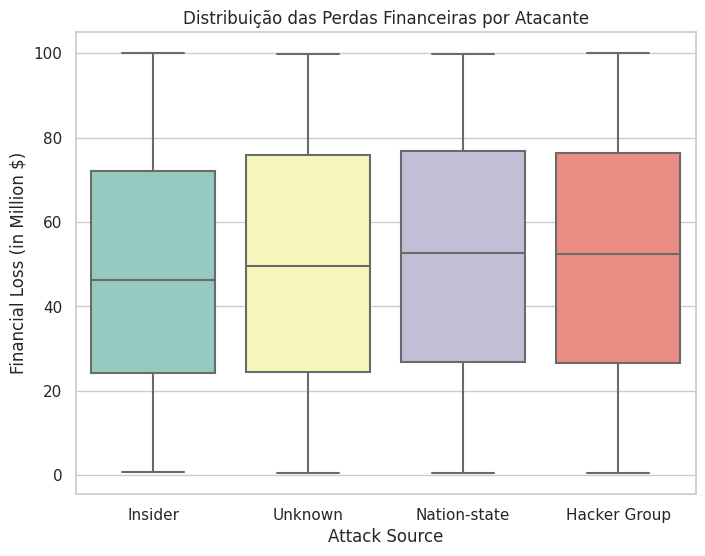

In [19]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x="Attack Source", y="Financial Loss (in Million $)", palette="Set3")
plt.title("Distribuição das Perdas Financeiras por Atacante")
plt.show()


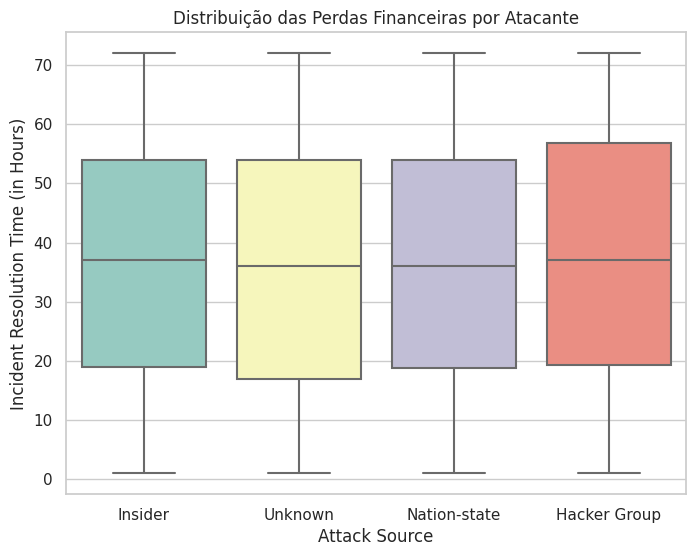

In [20]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x="Attack Source", y="Incident Resolution Time (in Hours)", palette="Set3")
plt.title("Distribuição das Perdas Financeiras por Atacante")
plt.show()


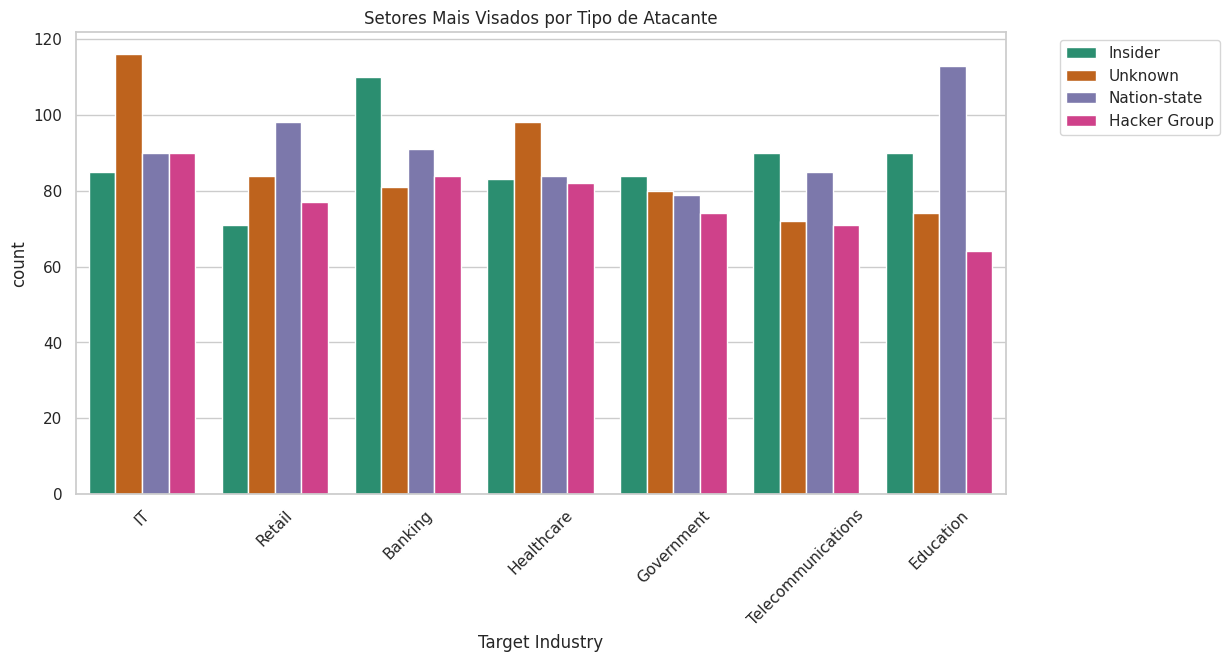

In [21]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, x="Target Industry", hue="Attack Source", palette="Dark2")
plt.title("Setores Mais Visados por Tipo de Atacante")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Comentário sobre a análise bivariada

A análise bivariada não revelou padrões novos ou relações fortes entre variáveis.  
O que se observa é justamente o que já esperávamos: um **dataset bem distribuído e balanceado**, resultado de sua **natureza sintética**.  

Esse comportamento reforça que as associações entre variáveis foram propositalmente suavizadas, de forma a não privilegiar nenhum preditor isolado.  
Assim, o desafio de modelagem não está em correlações simples, mas em capturar **combinações complexas** de variáveis para diferenciar os atacantes.


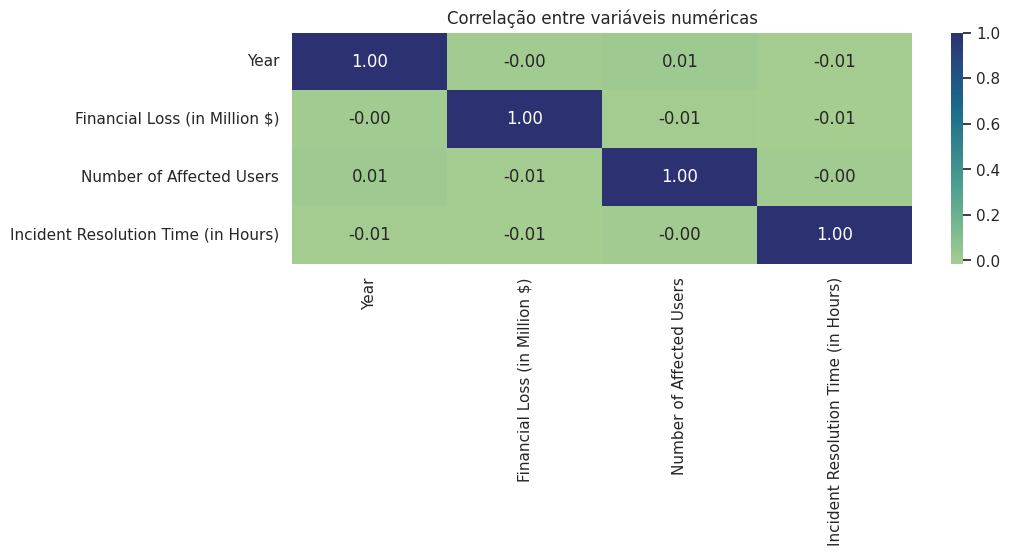

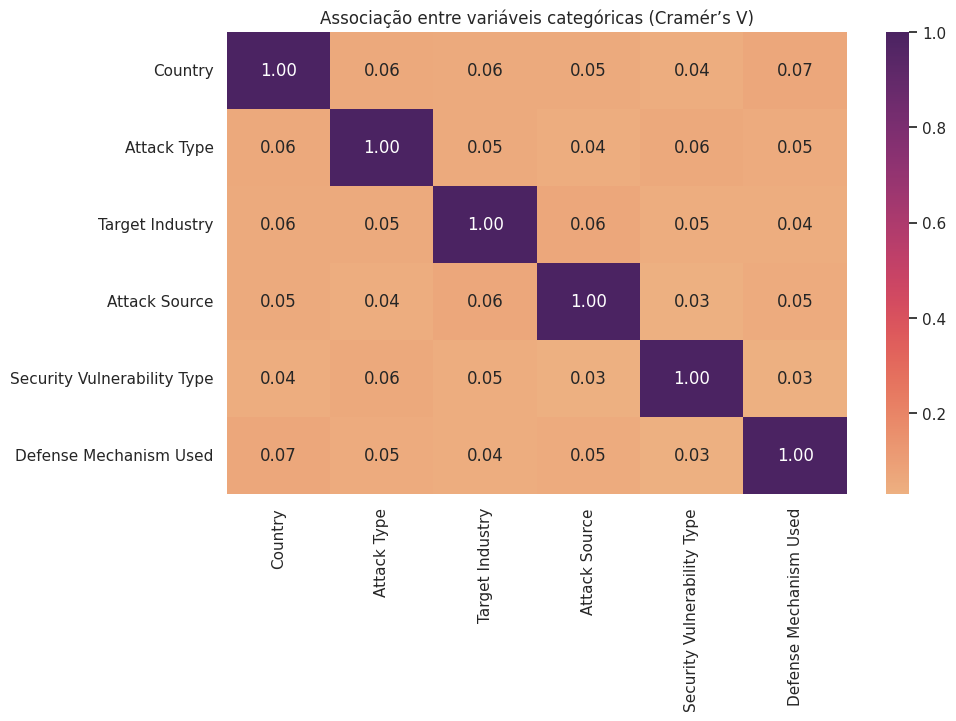

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency

# ========================
# 1. Correlação Numérica
# ========================
num_cols = df.select_dtypes(include='number').columns

corr_num = df[num_cols].corr(method="pearson")

plt.figure(figsize=(10,3))
sns.heatmap(corr_num, annot=True, cmap="crest", fmt=".2f")
plt.title("Correlação entre variáveis numéricas")
plt.show()


# ========================
# 2. Correlação Categórica (Cramér’s V)
# ========================
def cramers_v(x, y):
    """Calcula Cramér’s V entre duas variáveis categóricas"""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

cat_cols = df.select_dtypes(include='object').columns

# Matriz de Cramér’s V
cramer_matrix = pd.DataFrame(
    np.zeros((len(cat_cols), len(cat_cols))),
    index=cat_cols,
    columns=cat_cols
)

for col1 in cat_cols:
    for col2 in cat_cols:
        if col1 != col2:
            cramer_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])
        else:
            cramer_matrix.loc[col1, col2] = 1.0

plt.figure(figsize=(10,6))
sns.heatmap(cramer_matrix, annot=True, cmap="flare", fmt=".2f")
plt.title("Associação entre variáveis categóricas (Cramér’s V)")
plt.show()


### Interpretação das correlações e independência entre variáveis

A análise de correlações confirmou que o dataset **não apresenta colinearidade forte** entre as variáveis.  
Isso traz algumas implicações importantes para a modelagem:

- **Ausência de colinearidade forte**  
  → Não exigem técnicas como PCA ou remoção de variáveis redundantes.  
  → Podemos manter praticamente todas as variáveis sem risco de sobreposição informacional significativa.  

- **Variáveis independentes**  
  → Cada variável carrega informação própria, contribuindo em diferentes regiões do espaço de decisão.  
  → Essa diversidade tende a enriquecer a capacidade do modelo de capturar padrões sutis.  

- **Problema de classificação desafiador**  
  → Como não há correlações altas, os atacantes não podem ser facilmente diferenciados por uma única variável.  
  → A separação deve ocorrer por **combinações complexas de atributos**, o que favorece algoritmos como **Random Forest** e **XGBoost**, capazes de explorar interações não lineares.  

- **Importância futura das features**  
  → Nenhuma variável se destacou estatisticamente nesta fase exploratória.  
  → A análise de *feature importance* (via ganho de informação, *permutation importance* ou SHAP values) será fundamental para revelar quais variáveis realmente ajudam a distinguir os atacantes na prática.  

**Resumo:** O dataset, embora sintético, foi construído de forma a criar um desafio real de classificação: não há “atalhos fáceis” via correlações simples, exigindo modelos mais sofisticados para capturar relações complexas entre variáveis.


## 4.3 Cardinalidade das Features

Um ponto importante ao avaliar as variáveis é a **cardinalidade**, ou seja, o número de valores distintos em cada feature.  
Essa análise é relevante principalmente quando utilizamos modelos baseados em árvores de decisão e, posteriormente, realizamos interpretação via *feature importance*.  

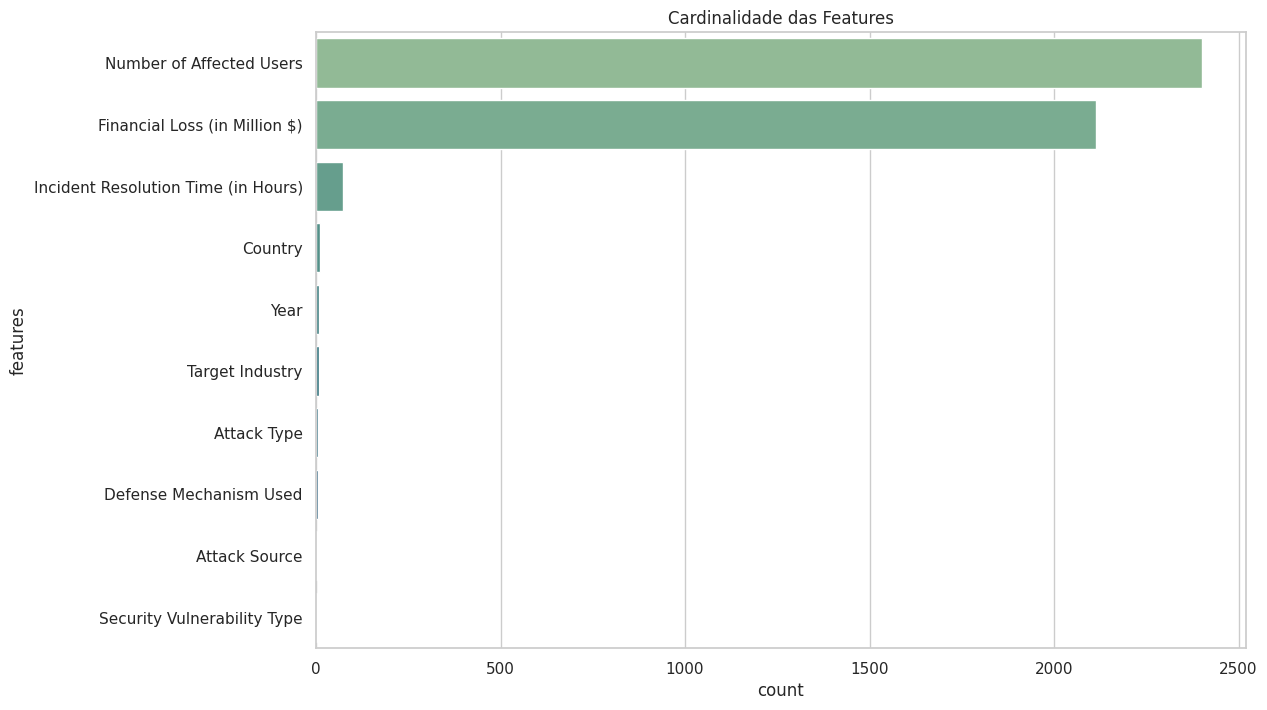

In [26]:
# Contar valores únicos por feature
unique_df = pd.DataFrame(df.nunique()).reset_index()
unique_df.columns = ['features', 'count']

# Ordenar para ficar mais fácil de visualizar
unique_df = unique_df.sort_values(by="count", ascending=False)

# Plotar
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(
    y="features", x="count",
    data=unique_df,
    palette="crest", orient='h', ax=ax
)

ax.set_title("Cardinalidade das Features")
plt.show()


De acordo com Gilles Louppe (2014), a cardinalidade impacta diretamente a importância atribuída a uma variável nesses modelos.  
- **Features contínuas** e **categóricas com muitos níveis** tendem a apresentar importâncias artificialmente maiores,  
mesmo que não sejam de fato mais preditivas.  
- Isso acontece porque tais variáveis oferecem mais oportunidades de gerar bons *splits* por acaso durante o treinamento.  

No nosso caso, é esperado que variáveis como **`Number of Affected Users`** e **`Financial Loss (in Million $)`** tenham suas importâncias infladas, justamente pela sua alta cardinalidade.  

Por esse motivo, ao avaliar a importância de variáveis, é recomendado ter cuidado e utilizar métodos mais robustos, como:  
- **Permutation Importance**, que mede a queda de performance ao embaralhar uma variável.  
- **SHAP values**, que avaliam a contribuição marginal de cada feature para a previsão.  

📖 Referência: [Understanding Variable Importances in Forests of Randomized Trees (Louppe, 2014)](https://arxiv.org/abs/1407.7502)

# 5. Data Preparation

Nesta etapa, preparamos os dados do conjunto de **treino** para que possam ser usados de forma eficiente pelos algoritmos de machine learning.  
O objetivo é garantir que o modelo receba variáveis consistentes, relevantes e representadas em um formato adequado.

- **Separação treino/teste:** já foi realizada previamente com base no ano, garantindo que o teste simule dados futuros e não influencie a análise nem o preparo.  
- **Valores faltantes:** não foram encontrados no dataset, dispensando imputação.  
- **Valores inválidos:** também não foram identificados registros inconsistentes (ex.: negativos em variáveis que deveriam ser positivas).  
- **Codificação de variáveis categóricas:** não será feita (como *One-Hot Encoding*), pois utilizaremos **modelos baseados em árvores**, que conseguem lidar diretamente com variáveis categóricas codificadas como inteiros.  
- **Escalonamento:** não será aplicado, uma vez que algoritmos de árvore não são sensíveis à escala dos atributos.  
- **Feature Engineering:** não será realizada nesta primeira versão. No entanto, no futuro, seria possível criar atributos derivados (e.g., interações entre variáveis categóricas, cruzamentos por setor/ataque) para enriquecer o espaço de decisão do modelo.

---

## Por que não usaremos modelos baseados em distância?

📊 **Modelos baseados em distância** (ex.: KNN, SVM com kernel RBF) apresentam algumas limitações neste dataset:

### 1. Distribuições uniformes  
- As variáveis numéricas (*Financial Loss*, *Number of Affected Users*, *Incident Resolution Time*) são quase uniformes, sem concentração em faixas específicas.  
- Isso significa que os pontos estão espalhados de forma relativamente homogênea no espaço.  
- Em teoria, isso **não favorece muito modelos de distância**, porque não há aglomerações naturais (clusters) que esses métodos poderiam explorar.

### 2. Separabilidade complexa  
- Já vimos que não existem correlações fortes → os atacantes diferem em **combinações complexas** de variáveis.  
- Modelos de distância tendem a ser “preguiçosos”: não aprendem regras, apenas memorizam vizinhos.  
- Nesse cenário, é mais provável que **árvores e ensembles (Random Forest, XGBoost, LightGBM)** se saiam melhor, pois exploram interações não lineares de forma mais eficiente.

---

### Resumo
- O dataset já está em formato adequado para ser utilizado em **modelos baseados em árvores** (Random Forest, XGBoost, LightGBM), sem necessidade de transformações adicionais neste momento.  
- No entanto, no **processo de machine learning, o ideal é sempre testar diferentes classes de algoritmos**, já que resultados práticos podem surpreender.  
- Por motivos de foco e consistência, neste estudo **iremos nos concentrar apenas em modelos baseados em árvores**.


# 6. Baseline de Classificação (Attack Source)

Antes de treinar modelos, definimos **baselines** para estabelecer um nível mínimo de desempenho.  
Essas linhas de base servem como referência: qualquer modelo “sério” deve superá-las.

**Princípios:**
- **Sem vazamento:** estimamos a baseline **apenas com o treino** e avaliamos **no teste temporal**.
- **Métricas:** usaremos **Log Loss** (probabilidades), **F1-Macro** (justiça entre classes) e **Accuracy** (auxiliar).

**Baselines adotadas:**
1. **Sempre prever a moda (classe mais frequente do treino)**  
   - Produz uma distribuição “degenerada” (probabilidade 1.0 na moda, 0.0 nas demais).  
   - Tende a ter **Log Loss ruim**, mas é uma referência simples.

2. **Prever as proporções (priors) observadas no treino**  
   - Atribui a todos os exemplos a mesma distribuição de probabilidade = frequências das classes no treino.  
   - Dá uma **baseline probabilística** mais justa; seu modelo deve ter **Log Loss < Log Loss dos priors**.

> Observação: as métricas reportadas no **treino** são apenas diagnósticas. A decisão deve se basear no **teste temporal**, pois simula produção.


In [27]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss, accuracy_score, f1_score

# =========================
# Configuração
# =========================
TARGET = "Attack Source"

# Garantir que train_df e test_df já existam a partir do split temporal
assert TARGET in train_df.columns and TARGET in test_df.columns, "Verifique se o split temporal foi executado."

# -------------------------
# Encode do alvo com base no TREINO (sem olhar o teste)
# -------------------------
le = LabelEncoder()
y_train = le.fit_transform(train_df[TARGET])
y_test  = le.transform(test_df[TARGET])  # usa o mesmo encoder

n_classes = len(le.classes_)

# =========================
# 1) Baseline: Sempre a MODA (calculada no treino)
# =========================
counts_train = np.bincount(y_train, minlength=n_classes)
majority_idx = counts_train.argmax()
majority_class = le.classes_[majority_idx]

# Probabilidades degeneradas (treino e teste)
y_proba_majority_train = np.zeros((len(y_train), n_classes), dtype=float)
y_proba_majority_train[:, majority_idx] = 1.0

y_proba_majority_test = np.zeros((len(y_test), n_classes), dtype=float)
y_proba_majority_test[:, majority_idx] = 1.0

# Métricas no TREINO (diagnóstico)
ll_majority_tr = log_loss(y_train, y_proba_majority_train, labels=np.arange(n_classes))
acc_majority_tr = accuracy_score(y_train, np.full_like(y_train, majority_idx))
f1m_majority_tr = f1_score(y_train, np.full_like(y_train, majority_idx), average="macro")

# Métricas no TESTE (principal)
ll_majority_te = log_loss(y_test, y_proba_majority_test, labels=np.arange(n_classes))
acc_majority_te = accuracy_score(y_test, np.full_like(y_test, majority_idx))
f1m_majority_te = f1_score(y_test, np.full_like(y_test, majority_idx), average="macro")

print(f"[Baseline - Moda] Classe (treino): {majority_class}")
print(f"  TREINO -> LogLoss={ll_majority_tr:.4f} | Acc={acc_majority_tr:.4f} | F1-macro={f1m_majority_tr:.4f}")
print(f"  TESTE  -> LogLoss={ll_majority_te:.4f} | Acc={acc_majority_te:.4f} | F1-macro={f1m_majority_te:.4f}")

# =========================
# 2) Baseline: PRIORS do treino
# =========================
priors = counts_train / counts_train.sum()          # distribuição empírica (treino)
y_proba_priors_train = np.tile(priors, (len(y_train), 1))
y_proba_priors_test  = np.tile(priors, (len(y_test), 1))

# Rótulo argmax das priors (equivale à moda)
y_pred_priors_train = np.full_like(y_train, priors.argmax())
y_pred_priors_test  = np.full_like(y_test, priors.argmax())

# Métricas no TREINO (diagnóstico)
ll_priors_tr = log_loss(y_train, y_proba_priors_train, labels=np.arange(n_classes))
acc_priors_tr = accuracy_score(y_train, y_pred_priors_train)
f1m_priors_tr = f1_score(y_train, y_pred_priors_train, average="macro")

# Métricas no TESTE (principal)
ll_priors_te = log_loss(y_test, y_proba_priors_test, labels=np.arange(n_classes))
acc_priors_te = accuracy_score(y_test, y_pred_priors_test)
f1m_priors_te = f1_score(y_test, y_pred_priors_test, average="macro")

print(f"\n[Baseline - Priors] Probas (treino) = {dict(zip(le.classes_, np.round(priors, 3)))}")
print(f"  TREINO -> LogLoss={ll_priors_tr:.4f} | Acc={acc_priors_tr:.4f} | F1-macro={f1m_priors_tr:.4f}")
print(f"  TESTE  -> LogLoss={ll_priors_te:.4f} | Acc={acc_priors_te:.4f} | F1-macro={f1m_priors_te:.4f}")


[Baseline - Moda] Classe (treino): Nation-state
  TREINO -> LogLoss=26.4320 | Acc=0.2667 | F1-macro=0.1053
  TESTE  -> LogLoss=26.7924 | Acc=0.2567 | F1-macro=0.1021

[Baseline - Priors] Probas (treino) = {'Hacker Group': 0.226, 'Insider': 0.255, 'Nation-state': 0.267, 'Unknown': 0.252}
  TREINO -> LogLoss=1.3845 | Acc=0.2667 | F1-macro=0.1053
  TESTE  -> LogLoss=1.3869 | Acc=0.2567 | F1-macro=0.1021


# 7. Modelagem

Nesta etapa, construiremos e avaliaremos diferentes modelos de machine learning.  
Nosso fluxo de trabalho seguirá as boas práticas de projetos preditivos:

1. **Divisão do treino em treino/validação:**  
   - Usaremos **validação cruzada temporal** (*TimeSeriesSplit*) para respeitar a ordem cronológica dos dados.  
   - Isso garante que modelos sejam treinados apenas com informações do “passado” e avaliados em blocos de “futuro próximo”, simulando a realidade de produção.

2. **Algoritmos candidatos (todos baseados em árvores):**  
   - **Random Forest**  
   - **XGBoost**
   - **ExtraTrees**
   - **HistGB**
   
   > Escolhemos apenas modelos baseados em árvores porque eles lidam bem com variáveis categóricas, não exigem escalonamento e são adequados para cenários com relações não lineares e interações complexas entre variáveis.

3. **Otimização de hiperparâmetros:**  
   - Utilizaremos *RandomizedSearchCV* para buscar combinações ideais de hiperparâmetros.  
   - As métricas de avaliação serão **Log Loss** (para avaliar probabilidades) e **F1-Macro** (principal).  

4. **Seleção do melhor modelo:**  
   - Compararemos o desempenho médio nos folds de validação temporal.  
   - O melhor modelo será re-treinado no **conjunto completo de treino**.  

5. **Avaliação final:**  
   - Após escolher o modelo vencedor, faremos a **avaliação final no conjunto de teste temporal**.  
   - Isso simula a aplicação do modelo em produção, garantindo uma estimativa realista de performance.

---

### Estratégia de Validação Temporal

A validação cruzada temporal funciona assim:

- Os dados de treino são divididos em blocos ordenados no tempo.  
- Em cada *fold*, treinamos com um bloco inicial e validamos no bloco seguinte.  
- Repetimos o processo avançando na linha do tempo.  

Isso nos dá uma avaliação mais fiel à realidade do problema, evitando vazamento de informação e respeitando a cronologia dos ataques.

Exemplo de esquema (com 3 folds):

Treino [2015–2017] → Validação [2018]
Treino [2015–2018] → Validação [2019]
Treino [2015–2019] → Validação [2020]



In [30]:
# =========================
# 7. Modelagem com CV temporal (classificação Attack Source)
# =========================

import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, log_loss, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier

from scipy.stats import randint, uniform

# Tentar importar XGBoost e LightGBM se já estiverem no ambiente Kaggle
_HAS_XGB = True
_HAS_LGBM = True
try:
    from xgboost import XGBClassifier
except Exception:
    _HAS_XGB = False

try:
    from lightgbm import LGBMClassifier
except Exception:
    _HAS_LGBM = False

RANDOM_SEED = 42
N_SPLITS = 3            # nº de folds temporais no treino
N_ITER   = 30           # pode reduzir para 25-30 se precisar acelerar
N_JOBS   = -1

TARGET = "Attack Source"

# ---------------------------------
# 1) Preparar dados (TREINO e TESTE) já vindos do split temporal
# ---------------------------------
# Garantir ordenação temporal
train_df = train_df.sort_values("Year").reset_index(drop=True)
test_df  = test_df.sort_values("Year").reset_index(drop=True)

# Separar X / y
y_train_raw = train_df[TARGET].copy()
X_train_raw = train_df.drop(columns=[TARGET]).copy()

y_test_raw = test_df[TARGET].copy()
X_test_raw = test_df.drop(columns=[TARGET]).copy()

# Identificar colunas categóricas/numéricas
num_cols = X_train_raw.select_dtypes(include="number").columns.tolist()
cat_cols = X_train_raw.select_dtypes(include=["object","category"]).columns.tolist()

# Encoder do alvo
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test  = le.transform(y_test_raw)
n_classes = len(le.classes_)

# Pré-processamento: OrdinalEncoder p/ categóricas (robusto a categorias novas), passthrough p/ numéricas
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop"
)

# ---------------------------------
# 2) Definir modelos e espaços de hiperparâmetros (ajustados p/ ~2.4k amostras, 3 folds)
# ---------------------------------
models_and_params = []

# RandomForest
rf = RandomForestClassifier(
    random_state=RANDOM_SEED,
    n_jobs=-1,
    bootstrap=True
)
rf_params = {
    "clf__n_estimators":      randint(600, 1501),
    "clf__max_depth":         [None, 4, 8, 10, 12, 16],
    "clf__min_samples_split": randint(2, 11),
    "clf__min_samples_leaf":  randint(1, 5),
    "clf__max_features":      ["sqrt", "log2", 0.4, 0.6],
}
models_and_params.append(("RandomForest", rf, rf_params))

# ExtraTrees (rápido e forte)
et = ExtraTreesClassifier(
    random_state=RANDOM_SEED,
    n_jobs=-1,
    bootstrap=False
)
et_params = {
    "clf__n_estimators":      randint(600, 1501),
    "clf__max_depth":         [None, 8, 10, 12, 16],
    "clf__min_samples_split": randint(2, 11),
    "clf__min_samples_leaf":  randint(1, 5),
    "clf__max_features":      ["sqrt", "log2", 0.4, 0.6],
}
models_and_params.append(("ExtraTrees", et, et_params))

# HistGradientBoosting (sklearn)
hgb = HistGradientBoostingClassifier(
    loss="log_loss",
    learning_rate=0.05,
    max_iter=1200,
    random_state=RANDOM_SEED
)
hgb_params = {
    "clf__learning_rate":     uniform(0.02, 0.10),
    "clf__max_depth":         [None, 6, 8, 10, 12],
    "clf__max_leaf_nodes":    randint(31, 256),
    "clf__min_samples_leaf":  randint(1, 25),
    "clf__l2_regularization": uniform(0.0, 1.5),
}
models_and_params.append(("HistGB", hgb, hgb_params))

# XGBoost (se disponível)
if _HAS_XGB:
    xgb = XGBClassifier(
        objective="multi:softprob",
        num_class=n_classes,
        tree_method="hist",
        random_state=RANDOM_SEED,
        n_estimators=1400,
        n_jobs=-1
    )
    xgb_params = {
        "clf__learning_rate":     [0.03, 0.05, 0.07, 0.1],
        "clf__max_depth":         [4, 6, 8, 10],
        "clf__min_child_weight":  [1, 2, 3, 5, 8],
        "clf__subsample":         [0.7, 0.85, 1.0],
        "clf__colsample_bytree":  [0.7, 0.85, 1.0],
        "clf__reg_lambda":        [0.0, 0.5, 1.0, 1.5, 2.0],
        "clf__gamma":             [0.0, 0.1, 0.3],
    }
    models_and_params.append(("XGBoost", xgb, xgb_params))

# ---------------------------------
# 3) Validação cruzada temporal (scoring principal: Log Loss)
# ---------------------------------
tscv = TimeSeriesSplit(n_splits=N_SPLITS)

results = []
best_estimators = {}

for name, estimator, param_space in models_and_params:
    print(f"\n>>> Treinando e tunando: {name}")

    pipe = Pipeline(steps=[
        ("prep", preprocess),
        ("clf", estimator)
    ])

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_space,
        n_iter=N_ITER,
        scoring="neg_log_loss",      # métrica principal
        cv=tscv,
        verbose=1,
        random_state=RANDOM_SEED,
        n_jobs=N_JOBS,
        refit=True
    )

    search.fit(X_train_raw, y_train)

    results.append({
        "model": name,
        "best_log_loss_cv": -search.best_score_,  # converter para positivo
        "best_params": search.best_params_
    })
    best_estimators[name] = search.best_estimator_

res_df = pd.DataFrame(results).sort_values("best_log_loss_cv", ascending=True)
print("\nResultados (CV temporal, Log Loss):")
display(res_df)

# ---------------------------------
# 4) Selecionar o melhor modelo e avaliar no TESTE temporal
# ---------------------------------
top_row = res_df.iloc[0]
best_name = top_row["model"]
best_model = best_estimators[best_name]
print(f"\n>>> Melhor modelo por CV temporal: {best_name}")
print("Hiperparâmetros:", top_row["best_params"])

# Refit final no TREINO inteiro
best_model.fit(X_train_raw, y_train)

# Avaliação no TESTE (temporal)
y_proba_test = best_model.predict_proba(X_test_raw)
y_pred_test  = np.argmax(y_proba_test, axis=1)

ll  = log_loss(y_test, y_proba_test, labels=np.arange(n_classes))
f1m = f1_score(y_test, y_pred_test, average="macro")
acc = accuracy_score(y_test, y_pred_test)
cm  = confusion_matrix(y_test, y_pred_test, labels=np.arange(n_classes))

print(f"\n[TESTE temporal] {best_name} -> LogLoss={ll:.4f} | F1-Macro={f1m:.4f} | Accuracy={acc:.4f}")
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
print("\nMatriz de confusão (linhas=real, colunas=predito):")
display(cm_df)



>>> Treinando e tunando: RandomForest
Fitting 3 folds for each of 30 candidates, totalling 90 fits

>>> Treinando e tunando: ExtraTrees
Fitting 3 folds for each of 30 candidates, totalling 90 fits

>>> Treinando e tunando: HistGB
Fitting 3 folds for each of 30 candidates, totalling 90 fits

>>> Treinando e tunando: XGBoost
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Resultados (CV temporal, Log Loss):


,model,best_log_loss_cv,best_params
0,RandomForest,1.390244,"{'clf__max_depth': 4, 'clf__max_features': 'sq..."
1,ExtraTrees,1.397524,"{'clf__max_depth': 8, 'clf__max_features': 'sq..."
3,XGBoost,1.443131,"{'clf__subsample': 1.0, 'clf__reg_lambda': 0.0..."
2,HistGB,2.388728,"{'clf__l2_regularization': 1.3613497108891395,..."



>>> Melhor modelo por CV temporal: RandomForest
Hiperparâmetros: {'clf__max_depth': 4, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 691}

[TESTE temporal] RandomForest -> LogLoss=1.3888 | F1-Macro=0.2139 | Accuracy=0.2367

Matriz de confusão (linhas=real, colunas=predito):


,Hacker Group,Insider,Nation-state,Unknown
Hacker Group,8,61,48,27
Insider,9,60,54,16
Nation-state,2,77,47,28
Unknown,6,65,65,27


## Resultados, Discussão e Próximos Passos

### 📊 Comparação com as Baselines
Para avaliar a qualidade dos modelos, utilizamos duas baselines simples:

- **Baseline - Moda:** prever sempre a classe mais frequente (`Nation-state`).  
  - TESTE → `LogLoss=26.79 | Acc=0.257 | F1-Macro=0.102`  

- **Baseline - Priors:** prever probabilidades iguais às distribuições das classes no treino.  
  - TESTE → `LogLoss=1.387 | Acc=0.257 | F1-Macro=0.102`  

A baseline de **Priors** já se mostra muito mais informativa que a moda, alcançando LogLoss baixo, mas sem ganhos em F1-Macro ou Acurácia (já que sempre escolhe a classe majoritária).  

---

### 🤖 Modelos Avaliados
Rodamos quatro modelos baseados em árvores, com validação cruzada temporal (3 splits):

| Modelo         | LogLoss CV (médio) |
|----------------|--------------------|
| RandomForest   | **1.390**          |
| ExtraTrees     | 1.398              |
| XGBoost        | 1.443              |
| HistGB         | 2.389              |

➡️ O **RandomForest** apresentou o melhor desempenho em CV e confirmou no conjunto de TESTE:  
- **LogLoss=1.389 | F1-Macro=0.214 | Accuracy=0.237**

Isso representa um avanço real sobre as baselines — especialmente em F1-Macro, que dobrou em relação às referências (~0.10 → 0.21).  

---

### 📌 Interpretação dos Resultados
1. **LogLoss próximo ao baseline de Priors:**  
   O modelo ainda está bem parelho no LogLoss em relação à distribuição de probabilidades "ingênua". Isso mostra que o aprendizado do padrão de ataque ainda é difícil, isso pode se dar pelo fato da base de dados ter sido gerada sinteticamente.  

2. **Baixo F1-Macro e Accuracy:**  
   Apesar da melhora em relação à baseline, a classificação de atacantes específicos ainda é um desafio. A matriz de confusão revela forte sobreposição entre classes (`Insider`, `Hacker Group` e `Nation-state` são frequentemente confundidos).  

3. **RandomForest vs ExtraTrees/XGB:**  
   O RF se beneficiou de profundidade moderada (`max_depth=4`), evitando overfitting. Já o HistGB não conseguiu capturar sinal e teve LogLoss alto.  

---

### 🚀 Possíveis Melhorias Futuras
- **Feature Engineering:**  
  Criar variáveis derivadas, como interações entre `Attack Type × Industry`.  

- **Técnicas de Ensemble:**  
  Combinar previsões de RF, ET e XGB em um *stacking* pode capturar sinais complementares.

  
- **Explorar outros algoritmos:**  
  Tentar usar algoritmos baseados em distancia.  


- **Modelos probabilísticos ou semi-supervisionados:**  
  Considerar tratamento especial da classe **Unknown**, seja como outlier ou via modelos hierárquicos.  

- **Aumento de Dados (Data Augmentation):**  
  Como os dados são sintéticos, explorar geração de cenários com perturbações pode enriquecer os padrões.  

---

✅ **Resumo:** O modelo de **RandomForest superou as baselines**, conseguindo uma LogLoss parecida, porém duplicando o F1-Macro. Apesar disso, os resultados mostram que o problema é altamente desafiador, e avanços reais dependerão de feature engineering e técnicas de ensemble.  
